In [48]:
from rdkit import Chem
from rdkit.Chem import AllChem
from rdkit import DataStructs
from tqdm import tqdm
from rdkit import Chem
from rdkit.Chem import Draw
from rdkit.Chem import rdFMCS
from scipy.spatial import distance
from scipy.stats import pearsonr
from scipy.stats import fisher_exact
from scipy.stats.contingency import crosstab
from scipy.stats import hypergeom
from sklearn.manifold import TSNE
import random
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
import seaborn as sns
import pickle
import os


from spec2vec import Spec2Vec
from matchms import calculate_scores

from openeye import oechem

os.chdir('../raw_data')

#### Functions to load and or write to pickle files

In [121]:
class Files:
    def __init__(self, filename):
        self.file = filename
        
    def write_to_file(self, data):
        with open(self.file, 'wb') as f:
            pickle.dump(data, f) 
        return None
    
    def load_pickle(self):
        data = pd.read_pickle(self.file)
        return data
    
    def load_csv(self, sep, usecols=None):
        data = pd.read_csv(self.file, sep=sep, usecols=usecols)
        return data
        
        
    

# Assess Prediction Performance

##### Predict Structure from spectra Embeddings

1. Calculate:

    1. Euclidean Distance
    2. Cosine Distance
    3. Correlation

2. Calculate Tanimoto score of top scoring hits based on the above metric

3. Sample a few structures to draw

In [122]:
def predict(subject_df,query_df,dims,
            subject_embed='sdl_z2',
            metric='euc',
           query_embed='sdl_z1',
           top_k=20): #both dfs should have z1 and z2 coloumns

    # initiate an empty df 
    preds = pd.DataFrame()
    preds.index=[x for x in test_df['spec_id']] # set query spec id as rownames
    preds[f'top_{top_k}_{metric}'] = None
    preds[f'true_{metric}'] = None
    preds[f'top_{top_k}_inchi14'] = None
    preds[f'top_{top_k}_tanis'] = None
    preds[f'true_tanimoto'] = None # only necessary to check that our indexing is correct; true always tanis == 1
    

    
    # compute the distances and select top k
    
    for query_index, query in enumerate(tqdm(query_df[query_embed])): #(query z1)
        
        #calculate tanimotos if it does not meet threshold;pass
        
        query_id = query_df['spec_id'].iloc[query_index]
        query_inchi = query_df['inchikey14'].iloc[query_index]
        
        similarity = []
        
        
        #print(query_inchi)
        
        for subject in subject_df[subject_embed]:#(subject z2)
        
            #subject = subject_df.loc[subject_index,'z2']
            if metric == 'corr':
                corr = pearsonr(query[:dims], subject[:dims])[0]
                similarity.append(corr)
        
            if metric== 'euc':
                euc = distance.euclidean(query[:dims], subject[:dims])
                similarity.append(euc)
        
            if metric == 'cos':
                cos = distance.cosine(query[:dims], subject[:dims])
                similarity.append(cos)
        
        if metric == 'corr': # if corr then higher the better
            top_k_corr = np.sort(similarity)[::-1][:top_k]
            top_k_ichi = []
            top_k_tanis = []
            for corr in top_k_corr:
                
                subject_index = similarity.index(corr) # pick subject index
                inchi = subject_df['inchikey14'].iloc[subject_index]
                #print(inchi)
                top_k_ichi.append(inchi)
                
                
                #compute tanis
                smile1 = subject_df['smiles'].iloc[subject_index] #extract the subject smile
                smile2= query_df['smiles'].iloc[query_index]#extract the query smile  
                tani = tanimoto(smile1,smile2)
                top_k_tanis.append(tani)
            
            # update the df
            preds.at[query_id, f'top_{top_k}_{metric}'] = top_k_corr # add corr
            preds.at[query_id, f'top_{top_k}_inchi14' ] = top_k_ichi # add inchi of the predicted
            preds.at[query_id, f'top_{top_k}_tanis'] = top_k_tanis
                
                
            #compute true dist between query and the true structure
            if query_inchi in list(subject_df['inchikey14']):
                
                #extract true hit embeddings to compute true cosine distance
                true_subject_embed = subject_df.loc[subject_df['inchikey14'] == query_inchi, subject_embed].iloc[0]
                
                true_corr = pearsonr(query[:dims], true_subject_embed[:dims])[0]
                preds.at[query_id,f'true_{metric}'] = true_corr
                
                # also compute true tanimoto
                smile2= query_df['smiles'].iloc[query_index]
                true_smile = subject_df.loc[subject_df['inchikey14'] == query_inchi, 'smiles'].iloc[0]
                preds.at[query_id,f'true_tanimoto'] = tanimoto(true_smile,smile2) # smile2 == query  smile
                
#             else: 
#                 pass
            
        
        else: # if cos or euc, then lower the better
            top_k_dist = np.sort(similarity)[:top_k]
            top_k_ichi = []
            top_k_tanis = []
            for dist in top_k_dist:
                
                subject_index = similarity.index(dist)
                #print(subject_index)
                inchi = subject_df['inchikey14'].iloc[subject_index]
                top_k_ichi.append(inchi)
                
                #compute tanis
                smile1 = subject_df['smiles'].iloc[subject_index] #extract the subject smile
                smile2= query_df['smiles'].iloc[query_index]#extract the query smile  
                tani = tanimoto(smile1,smile2)
                top_k_tanis.append(tani)
            
            preds.at[query_id, f'top_{top_k}_{metric}'] = top_k_dist # add corr
            preds.at[query_id, f'top_{top_k}_inchi14'] = top_k_ichi # add inchi of the predicted
            preds.at[query_id, f'top_{top_k}_tanis'] = top_k_tanis
                
            #compute true dist between query and the true structure
            if query_inchi in list(subject_df['inchikey14']):
                
                #extract true hit embedding to compute true cosine distance              
                true_subject_embed = subject_df.loc[subject_df['inchikey14'] == query_inchi, subject_embed].iloc[0]
                
                true_dist = distance.cosine(query[:dims], true_subject_embed[:dims])
                preds.at[query_id,f'true_{metric}'] = true_dist
                
                
                # also compute true tanimoto
                smile2= query_df['smiles'].iloc[query_index]
                true_smile = subject_df.loc[subject_df['inchikey14'] == query_inchi, 'smiles'].iloc[0]
                preds.at[query_id,f'true_tanimoto'] = tanimoto(true_smile,smile2) # smile2 == query  smile
                
#             else:
#                 pass
                
            
            
    
    return preds
    

In [123]:
def embedding_similarity(hits, 
                         query_df,
                         subject_df,
                         method='ms2ds_vs_mol2vec'):
    
    
    embed_cos = []
    
    
    for query_index, subject_index in  hits.items():
        
#         if query_df['sdl_tanis'].iloc[query_index] < 0.8: # only needed when testing known analogues
#             continue

        # calculates cosine distance between the spec2vec query embeddings and mol2vec top hit embeddings
        if method == 'ms2ds_vs_mol2vec':
            spec_embed = query_df['ms2ds'].iloc[query_index]
            structure_embed = subject_df['mol2vec'].iloc[subject_index[0][0]]
        
            cos = distance.cosine(spec_embed, structure_embed[:200]) #len of mol2vec is 300 while ms2deepscore is 200
            embed_cos.append(cos)
        
        # calculates cosine distance between the spec2vec query embeddings and spec2vec top hit embeddings
        elif method == 'spec2vec_vs_spec2vec':
            spec_embed = query_df['spec2vec'].iloc[query_index]
            structure_embed = subject_df['spec2vec'].iloc[subject_index[0][0]]
        
            cos = distance.cosine(spec_embed, structure_embed) 
            embed_cos.append(cos)
            
        elif method == 'ms2ds_vs_ms2ds':
            spec_embed = query_df['ms2ds'].iloc[query_index]
            structure_embed = subject_df['ms2ds'].iloc[subject_index[0][0]]
        
            cos = distance.cosine(spec_embed, structure_embed) 
            embed_cos.append(cos)
        
        # calculates cosine distance between the mol2vec query embeddings and mol2vec top hit embeddings
        
        elif method == 'mol2vec_vs_mol2vec':
            spec_embed = query_df['mol2vec'].iloc[query_index]
            structure_embed = subject_df['mol2vec'].iloc[subject_index[0][0]]
        
            cos = distance.cosine(spec_embed, structure_embed) 
            embed_cos.append(cos)
            
       
    return embed_cos
        
    

In [124]:
# function to calculate pairwise tanimoto scores
def tanimoto(smi1, smi2):
    #molecule
    mol1 = Chem.MolFromSmiles(smi1)
    mol2 = Chem.MolFromSmiles(smi2)
    #fingerprint
    fp1 = Chem.RDKFingerprint(mol1)
    fp2 = Chem.RDKFingerprint(mol2)
    
    #similarity
    score = round(DataStructs.FingerprintSimilarity(fp1,fp2),4)
    return score

In [125]:
# function to calculate tanimoto scores for n hits returns a max tanimotos and {query:top_hit}
def get_tanimotos(preditions_dict,
                  subject_df,
                  query_df, 
                  metric,nn=20,
                 calculate_mcs=False):
    tanimotos = []
    pred = {} #key is the query index, value is the top hit index
    mcs = []
    for query_index, values in tqdm(preditions_dict.items()): # values == score(corr, euc or cosine)
        pred[query_index] = []
        
#         if query_index > 199:
#             break
        
        #select top n hits for each query based on correlation
        if metric == 'corr':
            top_hits = np.sort(values)[::-1][:nn] # higher corr the better
            
            #calculate tanimoto scores for each of the top 5 hits
            top_hits_scores = []
            top_hits_mcs = []
            subject_hit_indices = []
            for hit in top_hits:
                
                subject_index = values.index(hit)
                subject_hit_indices.append(subject_index) #to trace the index of the hits
                    
                smile1 = subject_df['smiles'].iloc[subject_index] #extract the subject smile
                smile2= query_df['smiles'].iloc[query_index]#extract the query smile 
                
                top_hits_scores.append(tanimoto(smile1,smile2))
                
                if calculate_mcs: # this guy takes forever so you may want to run tanis only
                    top_hits_mcs.append(mcs_score(smile1,smile2))
                #select the max tanimoto score 
            tanimotos.append(max(top_hits_scores))
            
            if calculate_mcs:
                mcs.append(max(top_hits_mcs))
                pred[query_index].append([subject_hit_indices[np.argmax(top_hits_scores)], #hit index based on tanimotos
                                      subject_hit_indices[np.argmax(top_hits_mcs)], #hit index based on mcs
                                      max(top_hits_scores),max(top_hits_mcs)]) #appends [top hit index,tanimoto, msc]
            else:
                pred[query_index].append([subject_hit_indices[np.argmax(top_hits_scores)], #hit index based on tanimotos
                                       #hit index based on mcs
                                      max(top_hits_scores)])
            
        #select closest n hits for each query based on cosine/euclidian distance
        else: #may be elif metric != 'corr'
            top_hits = np.sort(values)[:nn] #if its euc or cos; the lower the better
            #print(top_hits)
            #calculate tanimoto scores for each of the top 5 hits
            top_hits_scores = [] #for tanimoto
            top_hits_mcs = [] # for mcs
            subject_hit_indices = []
            for hit in top_hits:
                
                #print(hit)
                
                subject_index = values.index(hit)
                subject_hit_indices.append(subject_index) #to trace the index of the hits
                    
                smile1 = subject_df['smiles'].iloc[subject_index] #extract the subject smile
                smile2= query_df['smiles'].iloc[query_index]#extract the query smile 
                
                #calculate similarity scores
                top_hits_scores.append(tanimoto(smile1,smile2))
                
                if calculate_mcs: # this guy takes forever so you may want to run tanis only
                    top_hits_mcs.append(mcs_score(smile1,smile2))
            
            #select the max tanimoto score 
            tanimotos.append(max(top_hits_scores))
            
            if calculate_mcs:
                mcs.append(max(top_hits_mcs))
                pred[query_index].append([subject_hit_indices[np.argmax(top_hits_scores)], #hit index based on tanimotos
                                      subject_hit_indices[np.argmax(top_hits_mcs)], #hit index based on mcs
                                      max(top_hits_scores),max(top_hits_mcs)]) #appends [top hit index,tanimoto, msc]
            else:
                pred[query_index].append([subject_hit_indices[np.argmax(top_hits_scores)], #hit index based on tanimotos
                                       
                                      max(top_hits_scores) # tanimoto
                                          
                                         ] 
                                        )
                
        
    return [tanimotos,mcs], pred
    
    

In [126]:
def random_tanimoto(preditions_dict,
                subject_df,query_df):
    tanimotos = []
    
    for query_index, values in preditions_dict.items():
        subject_index = random.randint(0,len(values)) #randomly pick subject index as hits
        
        smile1 = subject_df['smiles'].iloc[subject_index] #extract the subject smile
        smile2 = query_df['smiles'].iloc[query_index]#extract the query smile 
        
        tanimotos.append(tanimoto(smile1,smile2))
    return tanimotos
        
        

In [127]:
# function to extract the query and subject molecule, its legend(class_tanimoto_with the hit), can also return tanis
def pick_hit_mols(hits_dict, 
              train_df,test_df,
              group=None,
              return_tanimoto=False,
              k=2,
              filterby='inchikey14', #if group == [cf_class], set filterby to 'cf_class'
              ): 
    query_mols = []
    hits_mols = []
    tanimoto = []
   
    query_labels = []
    hit_labels = []
    for query_index, subject_index in  hits_dict.items():
    
    
        query_smile = test_df['smiles'].iloc[query_index]
        query_class = test_df['cf_class'].iloc[query_index]
        query_inchi = test_df['inchikey14'].iloc[query_index]
        
        if group:
            
            if filterby == 'cf_class':
                if query_class not in group:
                    continue
            else:
                if query_inchi not in group:
                    continue
    
        if type(query_class) == float:
            query_class = 'NAN'
            #classes = [f'Query:\t{query_class}',]
    
        query_labels.append(f'Query_{query_index}: {query_class}')#else
    
        query = Chem.MolFromSmiles(query_smile)
    
        subject_smile = train_df['smiles'].iloc[subject_index[0][0]]
        subject = Chem.MolFromSmiles(subject_smile)
        cl = train_df['cf_class'].iloc[subject_index[0][0]]
        if type(cl) == float:
            cl = 'NAN'
        subject_class = f'\tHit_{query_index}: {cl}:\tTanimoto: {subject_index[0][1]}'
        #print(query_class,subject_class)
        hit_labels.append(subject_class)
        query_mols.append(query)
        hits_mols.append(subject) #to expand later to include top 5 hits
        tanimoto.append(subject_index[0][1])
        
        
         
    
    if return_tanimoto:
        return [query_mols, hits_mols],[query_labels,hit_labels],tanimoto
    else:
        return [query_mols, hits_mols],[query_labels,hit_labels]

In [128]:
#plot the distribution of the three top tanimotos from the three metrics
def plot_distribution(values, title,
                      savefig=False,
                      legends=None,xlab=None,
                      ylab=None,
                      palette = None,
                      fig_path=None
                     ):
    
    for i, val in enumerate(values):
        if palette:
            ax=sns.kdeplot(x=val, color=palette[i],shade=False)
            
        else:
            ax=sns.kdeplot(x=val,shade=True)
    
    plt.legend(labels=legends, loc='center left', fontsize=12)
    plt.xlabel(xlab, fontsize=15)
    plt.ylabel(ylab, fontsize=15)
    plt.title(label=title, fontsize=15)
    
    if savefig and fig_path:
        plt.savefig(fig_path,\
               transparent=False,bbox_inches = 'tight')
    plt.show()

In [129]:
def mcs_score(query_smile, target_smile, threshold=0.9):
    
    query_mol = Chem.MolFromSmiles(query_smile)
    target_mol = Chem.MolFromSmiles(target_smile)# will be a list later
    mols = [query_mol, target_mol]
    mcs = rdFMCS.FindMCS(mols,
                    completeRingsOnly=True,#should the ring be complete?  
                    ringMatchesRingOnly=False, #should ring atoms match elsewhere?
                    timeout=10, #timeout in seconds; Not exhaustive search
                    threshold=threshold,
                    )
    shared_atoms = mcs.numAtoms/query_mol.GetNumAtoms() # what fraction of atoms is shared between the query and hit
    
    # escape zerodivion error detected after running 93% in 12hrs ):
    try:
        shared_bonds = mcs.numBonds/query_mol.GetNumBonds()
    except ZeroDivisionError:
        shared_bonds = 0 # what fraction of bonds is shared between the query and hit
    
    score = (shared_atoms+(shared_bonds/100)) # following openeye chem library
    
    return round(score, 4)

In [130]:
def spec2vec_similarity(model_path,
                        query_spectrum, 
                        target_spectrum,
                        n_decimals=2):
        
        spectrum_documents = spec_documents = [SpectrumDocument(s, n_decimals=n_decimals)\
                              for s in spectra]
        model = gensim.models.Word2Vec.load(model_path)
        
        # Define similarity_function
        spec2vec_similarity = Spec2Vec(model=model, intensity_weighting_power=0.5,
                               allowed_missing_percentage=5.0)
        # Calculate scores on all combinations of reference spectrums and queries
        score = calculate_scores(query_spectra, 
                                  target_spectra, 
                                  spec2vec_similarity)
        
        return score

In [131]:
# group queries based on tanimoto scores with their top hit
def group_tanimotos(tanis):
    category = []
    for tani in tanis:
        if tani <= 0.5:
            category.append('Low (tanimoto=<0.5)')
        elif 0.5 < tani < 0.8:
            category.append('Medium (0.5<tanimoto<0.8)')
        elif tani >= 0.8:
            category.append('High (tanimoto>=0.8)')
        
    return category

<h1> Compute predictions from the final model <h1>

In [133]:
paths = ['./sdl_logs/sdl_optimized_params/train_df_max3_sdl_and_cca_final_model_z_scores.pickle',
         './sdl_logs/sdl_optimized_params/test_df_max3_sdl_and_cca_final_model_z_scores.pickle',
         #'./sdl_logs/sdl_optimized_params/val_df_max3_sdl_and_cca_final_model_z_scores.pickle'
        ]


train_df = Files(paths[0]).load_pickle()
test_df = Files(paths[1]).load_pickle()
test_df.head(3)

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class,cca_z1,cca_z2,sdl_z1,sdl_z2
5625,COc1ccc(cc1OC)C(=O)NCc2ccc(OCCN(C)C)cc2,QQQIECGTIMUVDS-UHFFFAOYSA-N,QQQIECGTIMUVDS,spec_id5019,"[0.7660381606480904, -2.9954168988462215, -12....","[0.0, 13.000274658203125, 0.35151147842407227,...","[-0.45550603, -3.2559516, -3.0893652, 5.457150...",Benzene and substituted derivatives,"[0.051531734505366716, -0.6290144322258142, 0....","[-0.3670569538963088, -0.7741333930951451, 0.1...","[-0.5074534, -0.19799042, -0.084220506, -0.090...","[-1.2729512, -0.20587964, -0.22160338, -0.5555..."
40023,COc1cc(OC)c2c(OC)c(-c3ccc4c(c3)OCO4)c(=O)oc2c1,PZYZNVLXKYMURF-UHFFFAOYSA-N,PZYZNVLXKYMURF,spec_id39710,"[4.160680518910307, -17.534900146210205, -20.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 63.7232666015625, 5....","[1.2124093, -3.7327924, -5.30343, 5.8895183, 0...",Isoflavonoids,"[-0.5501047970153369, 0.38237380309998087, 0.3...","[-0.4201982466143634, -0.10796739849747246, -0...","[1.0821751, -0.21904153, -0.2859266, 0.8517396...","[0.7512287, -0.21170664, -0.1404785, 1.031399,..."
32710,O=C2C(O)=C(OC=3C=C(OC1OC(CO)C(O)C(O)C1(O))C(OC...,AFCDXKGLUDDXCK-UHFFFAOYSA-N,AFCDXKGLUDDXCK,spec_id31385,"[4.156373062713153, 2.6467714749778737, -9.709...","[25.13886260986328, 20.056901931762695, 0.0, 0...","[3.884097, -4.328525, -8.565995, 3.9552908, 1....",Flavonoids,"[-0.0658633840961331, 0.9429675883808374, -1.8...","[-0.20775599360091013, 0.7636143826091808, -1....","[1.8711135, -0.21995814, -0.53303856, 1.526128...","[1.8491485, -0.2038337, -0.060643416, 1.56308,..."


Select only unique inchikey14 in the train_df which is our databse. There is no point computing the cosine distance of the same inchi more than once. for the queries all elements are used as spectra might vary in nature even for the same molecule.

In [134]:
# select unique inchikey14 and create a database from training set
train_df.drop_duplicates('inchikey14', inplace=True)
print(train_df.shape)

(17844, 12)


In [135]:
metrics = ['cos', 'corr']

models = ['sdl', 'cca']
size = 5
for metric in metrics:
    for model in models:
        print(f'\nModel {model}')
        # cosine distance
        predictions_df = predict(subject_df=train_df,\
                        query_df=test_df.head(size),dims=100,
                        subject_embed=f'{model}_z2', # base name of z scores cols in subject df
                       query_embed=f'{model}_z1', # base name of z scores cols in query df
                       metric=metric,
                                top_k=20)
    
#         print('\nComputing Distance is Completed successfully\n')
#        # tanimotos and hits
#         scores, hit = get_tanimotos(dist,subject_df=train_df,\
#                                     query_df=test_df.head(size),\
#                                     metric=metric)
    
        print('\nComputing Tanimoto and hits is Completed successfully\n')
        # write the distances to file
        Files(f'./sdl_logs/sdl_optimized_params/train_in_train/{model}_preds/{model}_final_model_train_in_train_{metric}_predictions_df.pickle').write_to_file(predictions_df)
    
#         del dist # rescue memory :) 
    
#         Files(f'./sdl_logs/sdl_optimized_params/{model}_preds/{model}_final_model_test_{metric}_tanimoto.pickle').write_to_file(scores[0]) # scores has [tanimoto, mcs]
#         Files(f'./sdl_logs/sdl_optimized_params/{model}_preds/{model}_final_model_test_{metric}_hits.pickle').write_to_file(hit)
    
#         del scores, hit # only load when actually using them.


Model sdl


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.39it/s]



Computing Tanimoto and hits is Completed successfully


Model cca


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:02<00:00,  1.96it/s]



Computing Tanimoto and hits is Completed successfully


Model sdl


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:04<00:00,  1.19it/s]



Computing Tanimoto and hits is Completed successfully


Model cca


100%|████████████████████████████████████████████████████████████████████████████████████| 5/5 [00:03<00:00,  1.26it/s]


Computing Tanimoto and hits is Completed successfully



<h2> Load DeepCCA Tanimoto scores from the final models </h2>

In [15]:
metrics = ['cos', 'corr', 'euc']

models = ['sdl', 'cca']
size = 5
tanis_dict = {}
for metric in metrics:
    tanis_dict[metric] = []
    for model in models:
        tani = Files(f'./sdl_logs/sdl_optimized_params/{model}_preds/{model}_final_model_test_{metric}_tanimoto.pickle').load_pickle()
        tanis_dict[metric].append(tani)
        

In [168]:
tanis_dict.keys()

dict_keys(['cos', 'corr', 'euc'])

In [16]:
len(tanis_dict['cos'][0])

8290

<h2> Plot Tanimots computed from Cosine, Correlation and Euclidean metric </h2>

In [16]:
deepcca_tanis_df = pd.DataFrame({'cos_DeepCCA': tanis_dict['cos'][0],
                                 'corr_DeepCCA': tanis_dict['corr'][0],
                                 'euc_DeepCCA': tanis_dict['euc'][0],
                                 'cos_CCA': tanis_dict['cos'][1],
                                 'corr_CCA': tanis_dict['corr'][1],
                                 'euc_CCA': tanis_dict['euc'][1],
                                })
deepcca_tanis_df.head()

,cos_DeepCCA,corr_DeepCCA,euc_DeepCCA,cos_CCA,corr_CCA,euc_CCA
0,0.5215,0.5215,0.5304,0.7291,0.4323,0.5304
1,0.4381,0.4381,0.4381,0.4916,0.4916,0.4933
2,0.8913,0.8913,0.8913,0.8720,0.8720,0.8720
3,0.9497,0.9497,0.9497,0.9329,0.9329,0.9329
4,0.6005,0.5995,0.5941,0.5313,0.5313,0.4145


C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]
C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


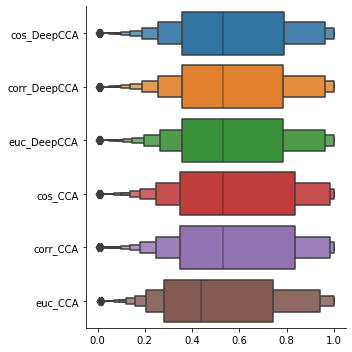

In [69]:
#plt.figure(figsize=(4.8, 6.4),dpi=100)
sns.catplot(data=deepcca_tanis_df,
            orient='h', kind='boxen')
plt.show()

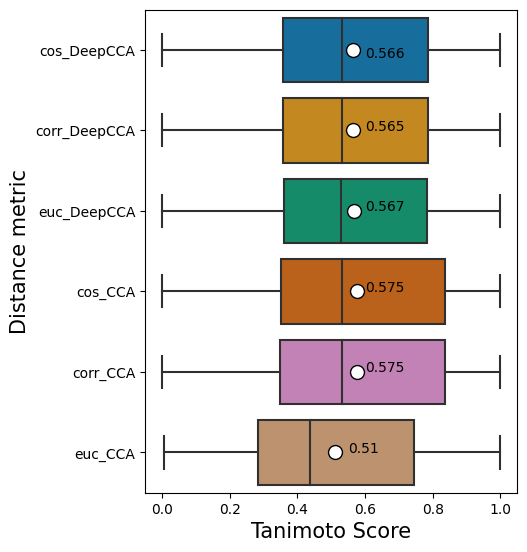

In [167]:
#palette = [sns.color_palette("colorblind")[0],
           #sns.color_palette("colorblind")[5],
           #sns.color_palette("colorblind")[6],
                 
          #] #random
plt.figure(figsize=(4.8, 6.4),dpi=100)
ax = sns.boxplot(data=deepcca_tanis_df, orient='h',
             showmeans = True,palette= sns.color_palette("colorblind"),
           meanprops={"marker":"o",
                      "markerfacecolor":"white", 
                      "markeredgecolor":"black",
                      "markersize":"10"})
#plt.legend(labels=list(deepcca_tanis_df.columns),loc=(1.04, 0.6))
#add mean tanimoto on the plot
plt.text(x=0.6,y=0.1,s=round(np.mean(tanis_dict['cos'][0]),3))
plt.text(x=0.6,y=1,s=round(np.mean(tanis_dict['corr'][0]),3))
plt.text(x=0.6,y=2,s=round(np.mean(tanis_dict['euc'][0]),3))
plt.xlabel('Tanimoto Score', fontsize=15)
plt.ylabel('Distance metric', fontsize=15)

plt.text(x=0.6,y=3,s=round(np.mean(tanis_dict['cos'][1]),3))
plt.text(x=0.6,y=4,s=round(np.mean(tanis_dict['corr'][1]),3))
plt.text(x=0.55,y=5,s=round(np.mean(tanis_dict['euc'][1]),3))
#ax.set_xticklabels([' ',' ',' ',' ',' ',' ' ])

plt.show()

In [227]:
models = ['sdl', 'cca']
tanis_dim_20_df = pd.DataFrame()
for model in models:
    tanis_dim_20_df[f'{model}_dim_20'] = Files(f'./sdl_logs/sdl_optimized_params/{model}_preds/{model}_final_model_test_cos_tanimoto_dim_20.pickle').load_pickle()
tanis_dim_20_df.head()    

,sdl_dim_20,cca_dim_20
0,0.5215,0.5000
1,0.4186,0.7085
2,0.8699,0.9331
3,0.9497,0.5317
4,0.5958,0.4704


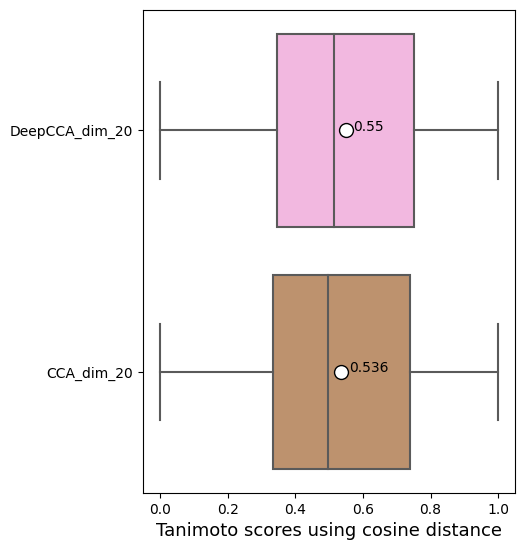

In [228]:
plt.figure(figsize=(4.8, 6.4),dpi=100)
ax = sns.boxplot(data=tanis_dim_20_df, orient='h',
             showmeans = True,palette= [sns.color_palette("colorblind")[6],sns.color_palette("colorblind")[5]],
           meanprops={"marker":"o",
                      "markerfacecolor":"white", 
                      "markeredgecolor":"black",
                      "markersize":"10"})\

plt.text(x=0.57,y=0,s=round(np.mean(tanis_dim_20_df['sdl_dim_20']),3))
plt.text(x=0.56,y=1,s=round(np.mean(tanis_dim_20_df['cca_dim_20']),3))
plt.xlabel('Tanimoto scores using cosine distance', fontsize=13)
plt.yticks([0,1], ['DeepCCA_dim_20', 'CCA_dim_20'])
plt.show()

<h2> Examine the embedding space based on the model performance </h2>

<h3> Categorize Tanimotos </h3>

set High scoring to greater or equal to 0.8

Medium scoring to greater than 0.5 and less than 0.8

Low scoring to less or equal to 0.5

In [20]:
deepcca_tanis = tanis_dict['cos'][0]
len(deepcca_tanis)

8290

In [21]:
deepcca_categories = group_tanimotos(deepcca_tanis)
cca_categories = group_tanimotos(tanis_dict['cos'][1])

In [22]:
# create a column in the df with category; also append the tanis to be sure they were well categorised
test_df['deepcca_category'] = deepcca_categories
test_df['cca_category'] = cca_categories

#test_df['sdl_tanimoto'] = sdl_mol_tanis[0]
#test_df['deepcca_tanimoto'] = tanis_dict[0]
#test_df['cca_tanimoto'] = tanis_dict[1]
test_df.head(3)

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class,cca_z1,cca_z2,sdl_z1,sdl_z2,deepcca_category,cca_category
5625,COc1ccc(cc1OC)C(=O)NCc2ccc(OCCN(C)C)cc2,QQQIECGTIMUVDS-UHFFFAOYSA-N,QQQIECGTIMUVDS,spec_id5019,"[0.7660381606480904, -2.9954168988462215, -12....","[0.0, 13.000274658203125, 0.35151147842407227,...","[-0.45550603, -3.2559516, -3.0893652, 5.457150...",Benzene and substituted derivatives,"[0.051531734505366716, -0.6290144322258142, 0....","[-0.3670569538963088, -0.7741333930951451, 0.1...","[-0.5074534, -0.19799042, -0.084220506, -0.090...","[-1.2729512, -0.20587964, -0.22160338, -0.5555...",Medium (0.5<tanimoto<0.8),Medium (0.5<tanimoto<0.8)
40023,COc1cc(OC)c2c(OC)c(-c3ccc4c(c3)OCO4)c(=O)oc2c1,PZYZNVLXKYMURF-UHFFFAOYSA-N,PZYZNVLXKYMURF,spec_id39710,"[4.160680518910307, -17.534900146210205, -20.4...","[0.0, 0.0, 0.0, 0.0, 0.0, 63.7232666015625, 5....","[1.2124093, -3.7327924, -5.30343, 5.8895183, 0...",Isoflavonoids,"[-0.5501047970153369, 0.38237380309998087, 0.3...","[-0.4201982466143634, -0.10796739849747246, -0...","[1.0821751, -0.21904153, -0.2859266, 0.8517396...","[0.7512287, -0.21170664, -0.1404785, 1.031399,...",Low (tanimoto=<0.5),Low (tanimoto=<0.5)
32710,O=C2C(O)=C(OC=3C=C(OC1OC(CO)C(O)C(O)C1(O))C(OC...,AFCDXKGLUDDXCK-UHFFFAOYSA-N,AFCDXKGLUDDXCK,spec_id31385,"[4.156373062713153, 2.6467714749778737, -9.709...","[25.13886260986328, 20.056901931762695, 0.0, 0...","[3.884097, -4.328525, -8.565995, 3.9552908, 1....",Flavonoids,"[-0.0658633840961331, 0.9429675883808374, -1.8...","[-0.20775599360091013, 0.7636143826091808, -1....","[1.8711135, -0.21995814, -0.53303856, 1.526128...","[1.8491485, -0.2038337, -0.060643416, 1.56308,...",High (tanimoto>=0.8),High (tanimoto>=0.8)


<h3> Extract the deepcca z scores </h3>

In [112]:
x_deepcca = np.array([i for i in test_df['sdl_z1']])

y_deepcca = np.array([i for i in test_df['sdl_z2']])


x_cca = np.array([i for i in test_df['cca_z1']])

y_cca = np.array([i for i in test_df['cca_z2']])



<h3> Compute t-SNE embeddings </h3>

In [113]:
tsne = TSNE(n_components=3, 
            verbose=0, 
            perplexity=10, # assuming these is related to neighbours
            n_iter=1000,
           init = 'pca',
           learning_rate = 'auto'
           )

x_deepcca_transformed = tsne.fit_transform(x_deepcca)
y_deepcca_transformed = tsne.fit_transform(y_deepcca)

x_cca_transformed = tsne.fit_transform(x_cca)
y_cca_transformed = tsne.fit_transform(y_cca)



C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have the standard deviation of PC1 equal to 1e-4 in 1.2. This will ensure better convergence.
  warnings.warn(
C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\sklearn\manifold\_t_sne.py:982: FutureWarning: The PCA initialization in TSNE will change to have th

No handles with labels found to put in legend.


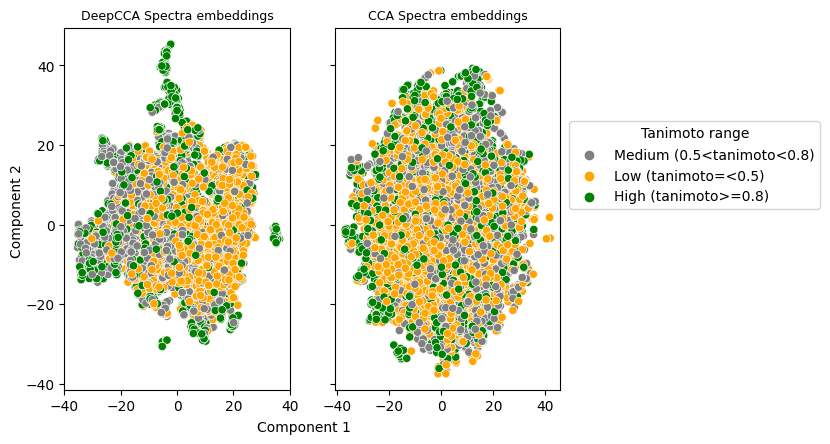

In [118]:
f, (ax1, ax2) = plt.subplots(1, 2, sharey=True,figsize=(6.4, 4.8),dpi=100)
sns.scatterplot(x=x_deepcca_transformed[:,0],
           y=x_deepcca_transformed[:,1], hue = deepcca_categories, 
                palette = ['grey', 'orange','green'],
                ax=ax1, legend=False)


sns.scatterplot(x=x_cca_transformed[:,0],
           y=x_cca_transformed[:,1], hue = cca_categories,
                palette = ['grey', 'orange','green'],
                )
#f.suptitle('SDL t-SNE plot colored by tanimoto score(query vs top hit)', fontsize=12)
ax1.set_title('DeepCCA Spectra embeddings', fontsize=9)
ax2.set_title('CCA Spectra embeddings', fontsize=9)
plt.legend(labels=deepcca_categories, loc=(1.04, 0.5))
#ax1.set_ylabel('PC 2', fontsize=15)
f.text(0.5, 0.04, 'Component 1', ha='center')
f.text(0.04, 0.5, 'Component 2', va='center', rotation='vertical')
handles, labels = ax2.get_legend_handles_labels()

ax1.legend(handles, labels, loc= (1.17, 0.5)) # hiding behind ax2 :)
plt.legend(loc= (1.04, 0.5), title ='Tanimoto range')
leg = ax1.legend()
leg.remove()
ax1.set(xlim=(-40, 40))
plt.show()

<h2> Perform Fisher exact test to see which classes are over represented in the high performing regions </h2>

In [101]:
# select classes under each category
high_class = test_df.loc[test_df['deepcca_category'] == 'High (tanimoto>=0.8)']
medium_class = test_df.loc[test_df['deepcca_category'] == 'Medium (0.5<tanimoto<0.8)']
low_class = test_df.loc[test_df['deepcca_category'] == 'Low (tanimoto=<0.5)']
print(len(high_class),len(medium_class),len(low_class))

2005 2486 3799


In [102]:
yes_no = []
for score in test_df['deepcca_category']:
    if score == 'High (tanimoto>=0.8)':
        yes_no.append('yes')
    else:
         yes_no.append('no')
test_df['group'] = [x for x in yes_no] 

In [103]:
table_df = test_df[['cf_class', 'group']]
table_df.shape

(8290, 2)

In [104]:
#creat contigency table for all classes
levels = [x for x in table_df['group']] # yes if high tanimoto, no if else
cf_class = [x for x in table_df['cf_class']]

(xclass, xlevels),count = crosstab(cf_class, levels)
count.shape

(250, 2)

In [105]:
xlevels

array(['no', 'yes'], dtype='<U3')

In [106]:
count[:5] #column1 == not high score,column2 == yes success(high score)

array([[ 2,  1],
       [16,  2],
       [ 2,  0],
       [ 2,  2],
       [ 1,  0]])

In [107]:
# fisher_eaxct test
metric = 'cos'
pval = []
M = count.sum()
class_total =[]
class_identified = []
success_rate = []
unsuccess_rate= [] # running out of variable names :)
all_success = []
all_unsuccess = []
for i in range(len(count)):
    x = count[i][1] # success for one class 
    n = count[i].sum() # total for one class
    n_x = n-x # no success for one class
    N = count[:,1].sum() #success for all classes
    N_x = N - x # total success minus x

    table = [[x, n_x], [N_x, (M - (n + N) + x)]]
    ods, p = fisher_exact(table) # two-sided ?
    pval.append(p)
    success_rate.append((x/n))
    unsuccess_rate.append((n_x/n))
    class_total.append(n)
    all_success.append((x/N))
    all_unsuccess.append((n_x/(M-N)))
    class_identified.append(x)

#creat df
high_enriched_df = pd.DataFrame({'cf_class':[x for x in xclass],
                            'pvalue':[x for x in pval],
                            'class_total': [x for x in class_total],
                            '#_high_tanimoto': [x for x in class_identified],
                           'class_high_tanimoto': [x*100 for x in success_rate],
                           'class_low_tanimoto': [x*100 for x in unsuccess_rate],
                            '%_high_tanimoto': [x*100 for x in all_success],
                            '%_low_tanimoto': [x*100 for x in all_unsuccess]}
                            
                          )

high_enriched_df = high_enriched_df.sort_values(['pvalue','class_high_tanimoto'],
                                                ascending = [True, False])


In [108]:
high_enriched_df.head(10)

,cf_class,pvalue,class_total,#_high_tanimoto,class_high_tanimoto,class_low_tanimoto,%_high_tanimoto,%_low_tanimoto
99,Glycerophospholipids,1.411785e-54,136,118,86.764706,13.235294,5.885287,0.286396
98,Glycerolipids,1.009739e-42,94,85,90.425532,9.574468,4.239401,0.143198
249,nan,8.129690e-34,265,155,58.490566,41.509434,7.730673,1.750199
28,Benzene and substituted derivatives,1.005909e-22,729,76,10.425240,89.574760,3.790524,10.389817
90,Flavonoids,5.193935e-15,441,179,40.589569,59.410431,8.927681,4.168656
13,Aporphines,1.644825e-12,42,32,76.190476,23.809524,1.596010,0.159109
135,Macroline alkaloids,1.158440e-05,8,8,100.000000,0.000000,0.399002,0.000000
38,Benzopyrans,1.247062e-05,131,12,9.160305,90.839695,0.598504,1.893397
185,Purine nucleotides,9.189137e-05,13,10,76.923077,23.076923,0.498753,0.047733
222,Tetracyclines,9.189137e-05,13,10,76.923077,23.076923,0.498753,0.047733


In [109]:
#drop some columns that arent useful in heatmap
high_enriched_df = high_enriched_df[high_enriched_df['class_total']>100]

new_df_high = high_enriched_df.drop(columns=['cf_class', 
                                             'class_total',
                                             'pvalue',
                                             '%_high_tanimoto',
                                             '#_high_tanimoto',
                                             '%_low_tanimoto'
                                            ])



from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
#df_scaled = scaler.fit_transform(new_df_high.to_numpy())
#new_df_high = pd.DataFrame(df_scaled, columns=[
 # 'ratio_class_high_tanimoto', 'ratio_class_not_high_tanimoto', 'high_tanimoto', 'not_high_tanimoto'])
new_df_high.head()

,class_high_tanimoto,class_low_tanimoto
99,86.764706,13.235294
249,58.490566,41.509434
28,10.425240,89.574760
90,40.589569,59.410431
38,9.160305,90.839695


In [110]:
high_enriched_df.head(10)

,cf_class,pvalue,class_total,#_high_tanimoto,class_high_tanimoto,class_low_tanimoto,%_high_tanimoto,%_low_tanimoto
99,Glycerophospholipids,1.411785e-54,136,118,86.764706,13.235294,5.885287,0.286396
249,nan,8.129690e-34,265,155,58.490566,41.509434,7.730673,1.750199
28,Benzene and substituted derivatives,1.005909e-22,729,76,10.425240,89.574760,3.790524,10.389817
90,Flavonoids,5.193935e-15,441,179,40.589569,59.410431,8.927681,4.168656
38,Benzopyrans,1.247062e-05,131,12,9.160305,90.839695,0.598504,1.893397
165,Peptidomimetics,5.507207e-04,153,56,36.601307,63.398693,2.793017,1.543357
121,Isoflavonoids,2.509164e-02,147,24,16.326531,83.673469,1.197007,1.957041
59,Cinnamic acids and derivatives,2.942344e-02,105,16,15.238095,84.761905,0.798005,1.416070
114,Indoles and derivatives,7.728873e-02,198,37,18.686869,81.313131,1.845387,2.561655
215,Steroids and steroid derivatives,9.660199e-02,439,121,27.562642,72.437358,6.034913,5.059666


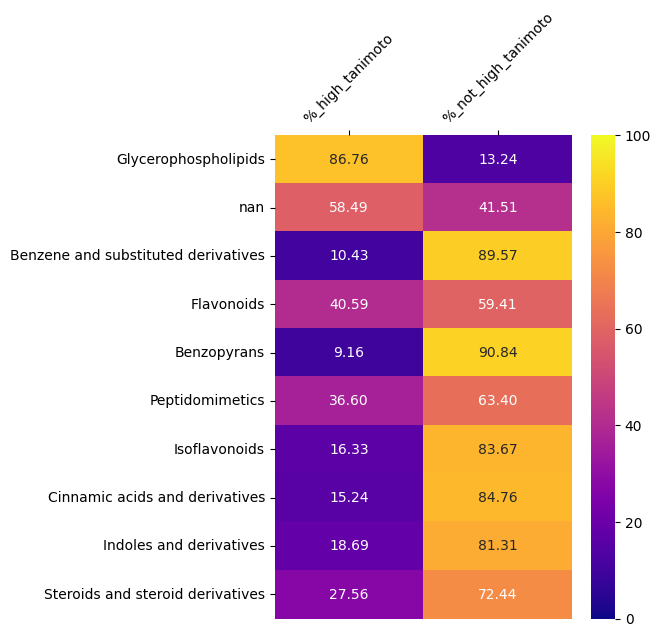

In [111]:
plt.figure(figsize=(4.8, 6.4),dpi=100)
lab = [x for x in high_enriched_df['cf_class'].head(10)]
ax=sns.heatmap(new_df_high.head(10), yticklabels = lab, vmin=0, vmax=100,cmap="plasma",annot=True,
          fmt=".2f")
#plt.title('Chemical class proportion in hits \nwith tanimoto > 0.8 vs hits with tanimoto < 0.8 \n')
#plt.savefig(f'./sdl_768_15_dims/heatmap_high_scoring_hits_by_{metric}_distance',bbox_inches = 'tight')
#plt.xlabel('Proportion')


ax.xaxis.tick_top() # x axis on top
ax.xaxis.set_label_position('top')
plt.xticks([0.5,1.5], labels=['%_high_tanimoto', '%_not_high_tanimoto'],rotation=45)
plt.show()

<h2> Distances before and After Deep(CCA) was applied </h2>

<h3> Select molecule pairs with high Tanimoto scores <h3>

In [72]:
#load tanimoto scores dataframe
all_tanimotos = Files('./GNPS_15_12_2021_pos_tanimoto_scores.pickle').load_pickle()

In [73]:
all_tanimotos.head(3)

inchikey14,LFTLOKWAGJYHHR,BQDXDGDOYPUUOD,VEPUCZUJLKAVNM,PXPSEALQIQRPQY,HDZVRBPBPCZCJG,SXJIZQPZESTWLD,JDOFZOKGCYYUER,WGTCMJBJRPKENJ,FCCDDURTIIUXBY,FDLLEBFMOIHMNM,...,RJAHLSXSRQXGGI,VKJTXCWIQDBMLE,NFIHKFSODJJLGC,NHLBOKNHQIEJIH,QABASLXUKXNHMC,XGVJWXAYKUHDOO,MNKNQKOOKLVXDB,CQKNELOTFUSOTP,MHCYVCDXRQGUFW,NMCMVEXMLSARCJ
inchikey14,,,,,,,,,,,,,,,,,,,,,
LFTLOKWAGJYHHR,1.000000,0.057353,0.042969,0.053269,0.069264,0.055453,0.048193,0.053296,0.052863,0.056204,...,0.049612,0.054762,0.053929,0.060065,0.049683,0.052980,0.049046,0.095833,0.050964,0.050159
BQDXDGDOYPUUOD,0.057353,1.000000,0.162866,0.215026,0.242169,0.176221,0.296270,0.195915,0.089888,0.460000,...,0.185547,0.430151,0.180851,0.218014,0.321244,0.297297,0.272672,0.147776,0.317369,0.253207
VEPUCZUJLKAVNM,0.042969,0.162866,1.000000,0.286316,0.113158,0.152310,0.208607,0.264908,0.082418,0.186620,...,0.157480,0.167925,0.233333,0.152523,0.228311,0.251228,0.226978,0.080844,0.289835,0.231393


In [77]:
#select analogues with >= 0.8 tanimoto scores. here we select only 2000 of them.
select = []
for test_inchi in tqdm(test_df['inchikey14']):    
    if len(select) >= 2000:
        break
    for train_inchi in train_df['inchikey14']:
        if train_inchi in select:
            continue
        if test_inchi in select:
            continue
        if test_inchi == train_inchi:
            continue
        else:
            #print(all_tanimotos.loc[test_inchi,train_inchi])
            score = all_tanimotos.loc[test_inchi,train_inchi]
            if score >= 0.8:
                select.append(test_inchi)
    
    
    #break
Files('./selected_inchis_for_dists_before_and_after_deepcca_no_self.pickle').write_to_file(select)

 35%|██████████████████████████▋                                                 | 2906/8290 [33:17<1:01:40,  1.45it/s]


In [82]:
select[:5]

['QQQIECGTIMUVDS',
 'AFCDXKGLUDDXCK',
 'KNJNBKINYHZUGC',
 'ALERZNQPBWWLMW',
 'YKXSHBQVFVTYIL']

In [80]:
analogues = test_df[test_df['inchikey14'].isin(select)]

In [85]:
analogues.head()

,smiles,inchi_key,inchikey14,spec_id,spec2vec,ms2ds,mol2vec,cf_class,cca_z1,cca_z2,sdl_z1,sdl_z2
5625,COc1ccc(cc1OC)C(=O)NCc2ccc(OCCN(C)C)cc2,QQQIECGTIMUVDS-UHFFFAOYSA-N,QQQIECGTIMUVDS,spec_id5019,"[0.7660381606480904, -2.9954168988462215, -12....","[0.0, 13.000274658203125, 0.35151147842407227,...","[-0.45550603, -3.2559516, -3.0893652, 5.457150...",Benzene and substituted derivatives,"[0.051531734505366716, -0.6290144322258142, 0....","[-0.3670569538963088, -0.7741333930951451, 0.1...","[-0.5074534, -0.19799042, -0.084220506, -0.090...","[-1.2729512, -0.20587964, -0.22160338, -0.5555..."
32710,O=C2C(O)=C(OC=3C=C(OC1OC(CO)C(O)C(O)C1(O))C(OC...,AFCDXKGLUDDXCK-UHFFFAOYSA-N,AFCDXKGLUDDXCK,spec_id31385,"[4.156373062713153, 2.6467714749778737, -9.709...","[25.13886260986328, 20.056901931762695, 0.0, 0...","[3.884097, -4.328525, -8.565995, 3.9552908, 1....",Flavonoids,"[-0.0658633840961331, 0.9429675883808374, -1.8...","[-0.20775599360091013, 0.7636143826091808, -1....","[1.8711135, -0.21995814, -0.53303856, 1.526128...","[1.8491485, -0.2038337, -0.060643416, 1.56308,..."
14421,C1OC2=C(O1)C=C(C=C2)C3=COC4=C(C3=O)C=CC(=C4)O,KNJNBKINYHZUGC-UHFFFAOYSA-N,KNJNBKINYHZUGC,spec_id12744,"[-2.8919476279177254, 7.136436073237354, -11.3...","[0.0, 10.869701385498047, 0.0, 0.9871315956115...","[1.584554, -2.3259673, -3.662932, 4.6133733, -...",Isoflavonoids,"[-0.2890197320080337, -0.3118134545186447, -0....","[-0.4108115967890674, -0.11284942912338826, -0...","[0.6291968, -0.22675322, 0.14513797, 0.7464487...","[0.64476126, -0.15404916, -0.12797499, 0.63583..."
24733,O=C(OC1C(OC(OCCC2=CC=C(O)C(O)=C2)C(OC(=O)C)C1O...,ALERZNQPBWWLMW-UHFFFAOYSA-N,ALERZNQPBWWLMW,spec_id23060,"[-4.41229641164563, -6.063199486461368, 5.2722...","[2.8529367446899414, 9.61679458618164, 15.8730...","[1.791454, -10.160973, -14.062275, 4.4526644, ...",Cinnamic acids and derivatives,"[-0.4426021969577932, 1.8091691591418246, -1.3...","[-0.045717320712869366, 0.8496795833727779, -1...","[0.9548313, 0.14880593, -0.3830789, 1.2951463,...","[1.6044742, -0.05239439, -0.3297751, 1.7345406..."
1554,CCCCCCCC[C@H](CC(=O)N[C@@H](CC(C)C)C(=O)N[C@H]...,YKXSHBQVFVTYIL-QBRPJVCNSA-N,YKXSHBQVFVTYIL,spec_id1415,"[22.739339103192883, 4.099443681571424, -0.388...","[0.0, 2.6264846324920654, 36.33338165283203, 0...","[-0.7859595, -9.460448, -9.593054, 6.750944, 1...",Peptidomimetics,"[0.2557153659576985, 2.626077715658153, 1.7261...","[0.2698508232841877, 2.1126756719217648, 1.536...","[0.28844205, -0.10560985, 10.159817, 0.5192892...","[0.3932817, 0.032470986, 8.970705, 0.30269888,..."


In [84]:
# write the df of selected analogues to file
Files('./analogues_df_for_dists_before_and_after_deepcca_no_self.pickle').write_to_file(analogues)

<h3> Compute the cosine distances before and after the models were applied </h3>

In [98]:

method = ['before', 'cca', 'deepcca']
embeddings = [['ms2ds', 'mol2vec'],['cca_z1', 'cca_z2'], ['sdl_z1','sdl_z2']]
#size = 5
for i, embed in enumerate(embeddings):
    print(f'\nModel {method[i]}')
    # cosine distance
    dist = predict(subject_df=train_df,
                    query_df=analogues,dims=100,
                    query_embed=embed[0], 
                    metric='cos')
    
    print('\nComputing Distance is Completed successfully\n')
     # tanimotos and hits
    scores, hit = get_tanimotos(dist,subject_df=train_df,
                                    query_df=analogues,
                                    metric='cos')
    
    print('\nComputing Tanimoto and hits is Completed successfully\n')
    # write the distances to file
    Files(f'./sdl_logs/sdl_optimized_params/distance_before_and_after_deepcca/{method[i]}_final_model_test_cos.pickle').write_to_file(dist)
    
    del dist # rescue memory :) 
    
    Files(f'./sdl_logs/sdl_optimized_params/distance_before_and_after_deepcca/{method[i]}_final_model_test_cos_tanimoto.pickle').write_to_file(scores[0]) # scores has [tanimoto, mcs]
    Files(f'./sdl_logs/sdl_optimized_params/distance_before_and_after_deepcca/{method[i]}_final_model_test_cos_hits.pickle').write_to_file(hit)
    
    del scores, hit # only load when actually using them.

In [96]:
analogues.shape

(2468, 12)

<h3> Extract top k predicted inchikey14s from the computed cosine distance </h3>

In [ ]:

methods = ['before', 'cca', 'deepcca']
analogues_20_preds = [{},{},{}]
cos_df = pd.DataFrame()
for i, method in enumerate(tqdm(methods)):
    cos_dict = Files(f'./sdl_logs/sdl_optimized_params/distance_before_and_after_deepcca/{method}_final_model_test_cos.pickle').load_pickle() # scores has [tanimoto, mcs]
    
    method_cos = []
    for query, dist_values in cos_dict.items():
        top_20_cos = np.sort(dist_values)[:20]
        top_20_inchis = []
        method_cos.append(np.min(top_20_cos))
        query_inchi = analogues['inchikey14'].iloc[query]
        for cos in top_20_cos:
            subject_index = dist_values.index(cos)
            #subject_hit_indices.append(subject_index)
            inchi = train_df['inchikey14'].iloc[subject_index]
            
            top_20_inchis.append(inchi)
        analogues_20_preds[i][query_inchi] =  top_20_inchis
        
    cos_df[method] = method_cos
    
    cos_df.head()    
Files('./sdl_logs/sdl_optimized_params/distance_before_and_after_deepcca/top_20_cos_preds_.pickle').write_to_file(analogues_20_preds)      

<h3> Plot analogues Tanimoto score distribution of the predictions before and after the models were applied </h3>

In [100]:
methods = ['before', 'cca', 'deepcca']

tanis = []
for method in methods:
    tani = Files(f'./sdl_logs/sdl_optimized_params/distance_before_and_after_deepcca/{method}_final_model_test_cos_tanimoto.pickle').load_pickle() # scores has [tanimoto, mcs]
    
    
    tanis.append(tani)

In [104]:
tanis_df = pd.DataFrame({'Before_Deep(CCA)':tanis[0],
                        'After_CCA':tanis[1],
                        'After_DeepCCA':tanis[2]})

C:\Users\lmeli\AppData\Local\Programs\Python\Python39\lib\site-packages\seaborn\categorical.py:82: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  plot_data = [np.asarray(s, float) for k, s in iter_data]


Text(0.5, 0, 'Tanimoto score')

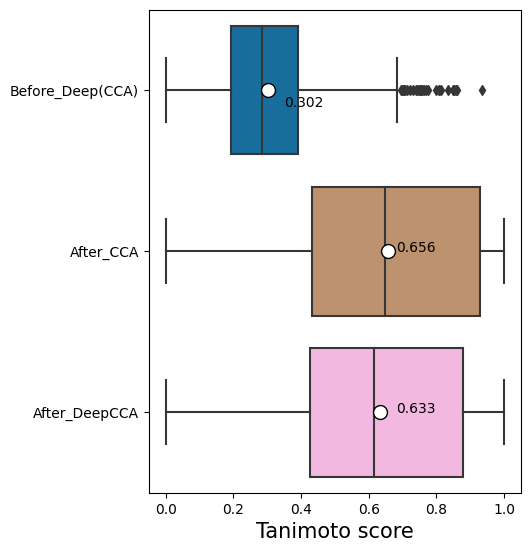

In [127]:
palette = [sns.color_palette("colorblind")[0],
           sns.color_palette("colorblind")[5],
           sns.color_palette("colorblind")[6],]
plt.figure(figsize=(4.8, 6.4),dpi=100)
ax = sns.boxplot(data=tanis_df, orient='h',
             showmeans = True, palette = palette,
           meanprops={"marker":"o",
                      "markerfacecolor":"white", 
                      "markeredgecolor":"black",
                      "markersize":"10"})
plt.text(x=0.35,y=0.1,s=round(np.mean(tanis[0]),3))
plt.text(x=0.68,y=1,s=round(np.mean(tanis[1]),3))
plt.text(x=0.68,y=2,s=round(np.mean(tanis[2]),3))
plt.xlabel('Tanimoto score', fontsize=15)

<h3> Examine the cosine distance of the analogues before and Deep(CCA) </h3>

In [120]:
methods = ['before', 'cca', 'deepcca']

cos_df = pd.DataFrame()
for method in methods:
    cos_dict = Files(f'./sdl_logs/sdl_optimized_params/distance_before_and_after_deepcca/{method}_final_model_test_cos.pickle').load_pickle() # scores has [tanimoto, mcs]
    
    method_cos = []
    for query, dist_values in cos_dict.items():
        method_cos.append(np.min(np.mean(dist_values)[:20]))
    cos_df[method] = method_cos
    cos_df.head()    
Files('./sdl_logs/sdl_optimized_params/distance_before_and_after_deepcca/minimum_cos_dist_nn_20.pickle').write_to_file(cos_df)      

In [138]:
#load the distance extracted above
cos_df = Files('./sdl_logs/sdl_optimized_params/distance_before_and_after_deepcca/minimum_cos_dist_nn_20.pickle').load_pickle()
cos_df.head()

,before,cca,deepcca
0,0.741609,0.487432,0.069494
1,0.778015,0.297145,0.009886
2,0.755551,0.438998,0.022226
3,0.809214,0.541897,0.065815
4,0.783484,0.300062,0.002932


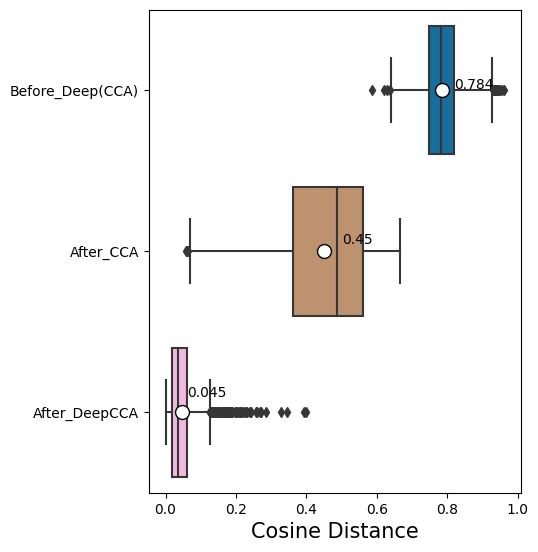

In [166]:
palette = [sns.color_palette("colorblind")[0],
           sns.color_palette("colorblind")[5],
           sns.color_palette("colorblind")[6],]
plt.figure(figsize=(4.8, 6.4),dpi=100)
ax = sns.boxplot(data=cos_df, orient='h',
             showmeans = True, palette = palette,
           meanprops={"marker":"o",
                      "markerfacecolor":"white", 
                      "markeredgecolor":"black",
                      "markersize":"10"})
plt.xlabel('Cosine Distance', fontsize=15)
plt.text(x=0.82,y=-0.01,s=round(np.mean(cos_df['before']),3))
plt.text(x=0.5,y=0.95,s=round(np.mean(cos_df['cca']),3))
plt.text(x=0.06,y=1.9,s=round(np.mean(cos_df['deepcca']),3))
plt.yticks(ticks=[0,1,2],labels=['Before_Deep(CCA)', 'After_CCA', 'After_DeepCCA'])
plt.show()

<h2> Examine the top 20 Accuracy of the models </h2>

In [45]:
analogues_20_preds = Files(f'./sdl_logs/sdl_optimized_params/distance_before_and_after_deepcca/top_20_cos_preds_.pickle').load_pickle() 

len(analogues_20_preds[0]) # some keys could be unique so the dataset will reduce than expected
#Files('./sdl_logs/sdl_optimized_params/distance_before_and_after_deepcca/top_20_cos_preds_.pickle').write_to_file(analogues_20_preds)      

2000

In [46]:
scores = []
#try this for the entire test dataset
methods = ['before','cca', 'deepcca']
train_inchis = [x for x in train_df['inchikey14']]
for i, top_20 in enumerate(analogues_20_preds): #['before', 'cca', 'deepcca']
    score = []
    count_present = 0
    count_absent = 0
    count_not_in_train = 0
    for label, preds in top_20.items():
        if label not in train_inchis:
            count_not_in_train += 1
            continue
            
        if label not in preds:
            #print(label)
            score.append(0)
            count_absent += 1
        else:
            count_present += 1
            indx = preds.index(label)
            score.append(round(indx/20,3))
            #print(indx)
        #break
    #print(np.mean(sum(score)/len(score)))
    scores.append(sum(score)/len(score))
    print(count_present, count_absent, count_not_in_train)
    #break

0 1338 662
223 1115 662
141 1197 662


In [47]:
scores

[0.0, 0.06236920777279518, 0.03733183856502242]

In [281]:
scores[1]*100

4.172499999999999